# Simulation analysis of "simplified connectome models"

<u>Circuits (O1 size, calibrated)</u>:
- Base circuit
- 1st-order hex0-EE rewired
- 2nd-order hex0-EE rewired
- 3rd-order hex0-EE rewired
- 4th-order hex0-EE rewired
- 5th-order hex0-EE rewired

<u>Simulation campaigns</u>:
- Spontaneous activity (10s)
- Stimulus-evoked activity (10s; 10 whisker flicks targeting hex0)

(Modified from [bernsteinconference2022/simulations_summary.ipynb](https://bbpgitlab.epfl.ch/conn/personal/pokorny/bernsteinconference2022/-/blob/main/simulations_summary.ipynb))

In [1]:
# Initialization
import numpy as np
import os
from datetime import datetime
from utils import extract_spikes, extract_rates, extract_single_cell_rates, compute_cell_rate_significance, extract_psths, extract_psths_per_layer
from utils import plot_spikes_per_layer, plot_per_layer, plot_cell_rate_histograms, plot_psths, plot_psths_per_layer

ORDINAL_DICT = {1: '1st', 2: '2nd', 3: '3rd', 4: '4th', 5: '5th'}


In [2]:
# Figs path
res_path = '/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked'
figs_path = os.path.join(res_path, 'figures_' + datetime.now().strftime('%Y%m%d'))
if not os.path.exists(res_path):
    os.makedirs(res_path)
if not os.path.exists(figs_path):
    os.makedirs(figs_path)
print(f'INFO: Results path: "{res_path}"')
print(f'INFO: Figs path: "{figs_path}"')

INFO: Results path: "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked"
INFO: Figs path: "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked/figures_20230904"


In [3]:
# Simulation paths
sim_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/SimplifiedConnectomeModels/simulations_v2'
sim_seed = 628462

order = [1] #, 2, 3, 4, 5]
circuit_names = ['SSCx-HexO1-Release-TC'] + [f'SSCx-HexO1-Release-TC__ConnRewireOrder{_ord}Hex0EE' for _ord in order]
plot_names = ['Original'] + [f'{ORDINAL_DICT[_ord]} order' for _ord in order]
sim_names_spont = ['SSCx-HexO1-Release-TC__Spont'] + [f'SSCx-HexO1-Release-TC__Spont__ConnRewireOrder{_ord}Hex0EE' for _ord in order]
sim_names_evoked = ['SSCx-HexO1-Release-TC__Evoked'] + [f'SSCx-HexO1-Release-TC__Evoked__ConnRewireOrder{_ord}Hex0EE' for _ord in order]
sim_configs_spont = {_c: os.path.join(sim_path, _sim, f'seed={sim_seed}', 'simulation_config.json') for _c, _sim in zip(circuit_names, sim_names_spont)}  # SONATA simulation config
sim_configs_evoked = {_c: os.path.join(sim_path, _sim, f'seed={sim_seed}', 'simulation_config.json') for _c, _sim in zip(circuit_names, sim_names_evoked)}  # SONATA simulation config

print('Spont sims:')
for _sim, _cfg in sim_configs_spont.items():
    assert os.path.exists(_cfg)
    print(f'  {_sim}')

t_stim = None
print('Evoked sims:')
for _sim, _cfg in sim_configs_evoked.items():
    assert os.path.exists(_cfg)
    _stim_file = os.path.join(os.path.split(_cfg)[0], 'stim_times.txt')
    assert os.path.exists(_stim_file)
    if t_stim is None:
        t_stim = np.loadtxt(_stim_file)
    else:
        np.testing.assert_array_equal(t_stim, np.loadtxt(_stim_file), 'ERROR: Stimulus time mismatch!')
    print(f'  {_sim} ({len(t_stim)} stimuli)')


Spont sims:
  SSCx-HexO1-Release-TC
  SSCx-HexO1-Release-TC__ConnRewireOrder1Hex0EE
Evoked sims:
  SSCx-HexO1-Release-TC (10 stimuli)
  SSCx-HexO1-Release-TC__ConnRewireOrder1Hex0EE (10 stimuli)


### Spontaneous activity

In [4]:
t_start = 2000 # (ms)
t_end = 12000 # (ms)
node_set = 'hex0'

spikes_dict = extract_spikes(circuit_names, sim_configs_spont, node_set=node_set, save_path=res_path, save_name='spikes_spont')
rates_dict = extract_rates(circuit_names, sim_configs_spont, node_set=node_set, t_start=t_start, t_end=t_end, save_path=res_path, save_name='rates_spont')
cell_rates_dict = extract_single_cell_rates(circuit_names, sim_configs_spont, node_set=node_set, t_start=t_start, t_end=t_end, save_path=res_path, save_name='cell_rates_spont.npz')

cell_rates_pval_dict = compute_cell_rate_significance(circuit_names, sim_configs_spont, cell_rates_dict['spk_rates'], node_set, save_path=res_path, save_name='cell_rates_spont_pval')
np.testing.assert_array_almost_equal(rates_dict['rates_exc_per_layer'], cell_rates_pval_dict['mean_exc_rates_per_layer'])  # Consistency check
np.testing.assert_array_almost_equal(rates_dict['rates_inh_per_layer'], cell_rates_pval_dict['mean_inh_rates_per_layer'])  # Consistency check


INFO: Spike data loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked/spikes_spont_hex0.npz"
INFO: Rate data loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked/rates_spont_hex0.npz"
INFO: Cell rate data loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked/cell_rates_spont.npz_hex0.npz"
INFO: Cell rate p-values loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked/cell_rates_spont_pval_hex0.npz"


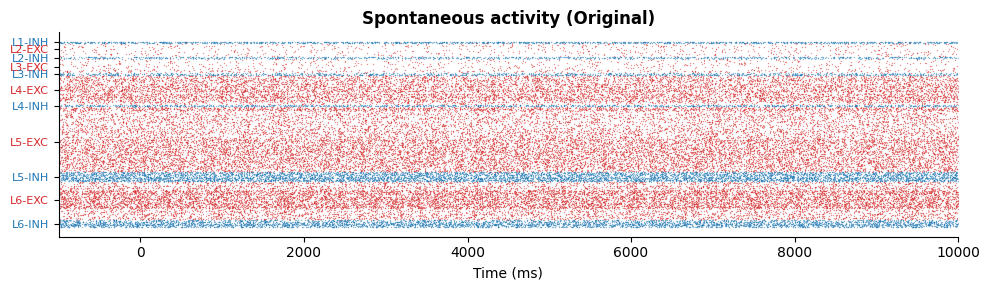

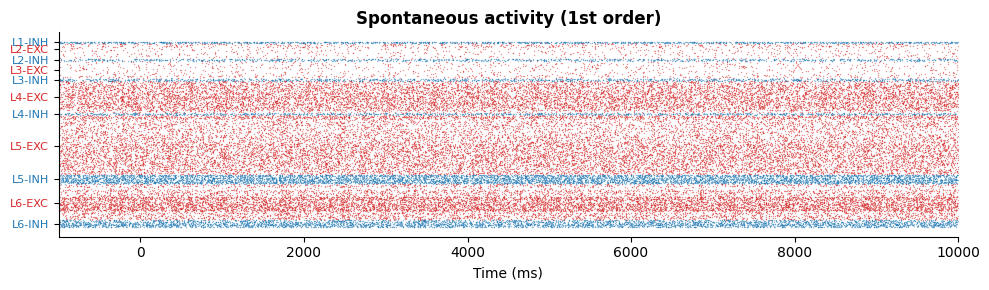

In [5]:
# Plot spike trains
t_start = -1000  # Rel. to t_zero (ms)
t_end = 10000  # Rel. to t_zero (ms)
t_zero = 2000  # Zero-offset (ms)

plot_spikes_per_layer(plot_names, spikes_dict['spk_exc_per_layer'], spikes_dict['spk_inh_per_layer'], t_start, t_end, t_zero, figsize=(10, 3), save_path=figs_path)

ALPHA LEVELS: *...0.01 **...0.001 ***...0.0001 

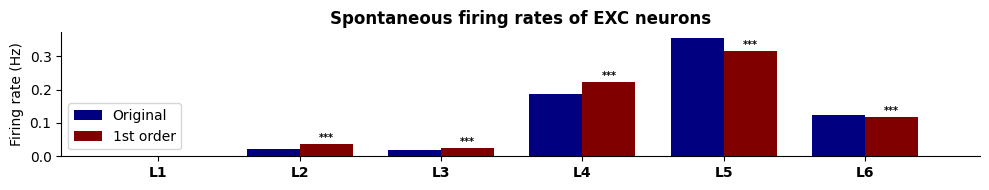

ALPHA LEVELS: *...0.01 **...0.001 ***...0.0001 

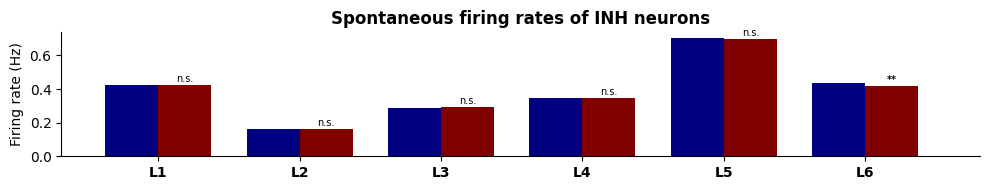

In [6]:
# Plot firing rates per layer
plot_per_layer(rates_dict['rates_exc_per_layer'], plot_names, 'Firing rate (Hz)', f'Spontaneous firing rates of EXC neurons', pvals=cell_rates_pval_dict['p_rates_exc'], log_y=False, figsize=(10, 2), show_legend=True, save_path=figs_path)
plot_per_layer(rates_dict['rates_inh_per_layer'], plot_names, 'Firing rate (Hz)', f'Spontaneous firing rates of INH neurons', pvals=cell_rates_pval_dict['p_rates_inh'], log_y=False, figsize=(10, 2), show_legend=False, save_path=figs_path)

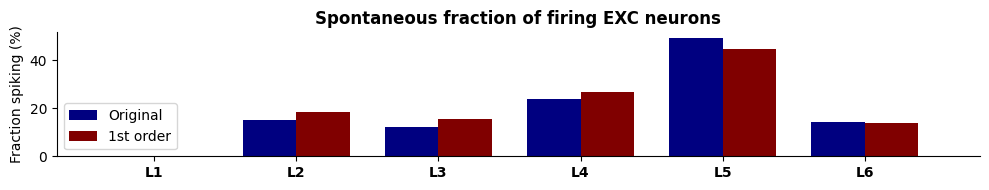

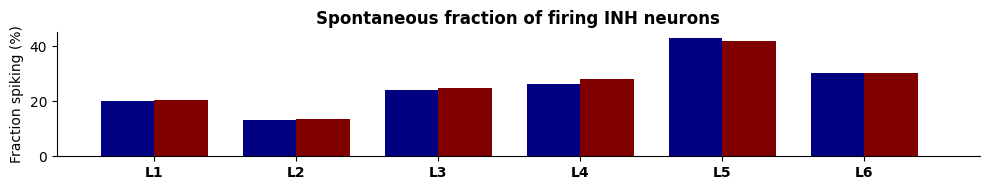

In [7]:
plot_per_layer(rates_dict['pct_exc_spiking_per_layer'], plot_names, 'Fraction spiking (%)', f'Spontaneous fraction of firing EXC neurons', log_y=False, figsize=(10, 2), show_legend=True, save_path=figs_path)
plot_per_layer(rates_dict['pct_inh_spiking_per_layer'], plot_names, 'Fraction spiking (%)', f'Spontaneous fraction of firing INH neurons', log_y=False, figsize=(10, 2), show_legend=False, save_path=figs_path)

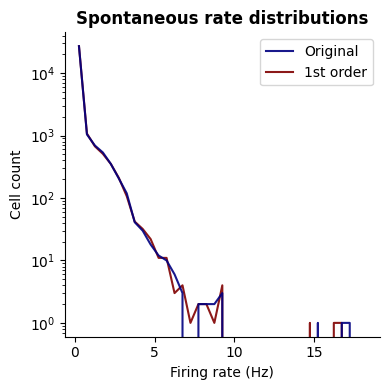

In [5]:
# Plot single-cell rate histograms
plot_cell_rate_histograms(cell_rates_dict['spk_rates'], plot_names, sim_type='Spontaneous', save_path=figs_path)

### Stimulus-evoked activity

In [4]:
t_start = 2000 # (ms)
t_end = 12000 # (ms)
node_set = 'hex0'

spikes_dict = extract_spikes(circuit_names, sim_configs_evoked, node_set=node_set, save_path=res_path, save_name='spikes_evoked')
rates_dict = extract_rates(circuit_names, sim_configs_evoked, node_set=node_set, t_start=t_start, t_end=t_end, save_path=res_path, save_name='rates_evoked')
cell_rates_dict = extract_single_cell_rates(circuit_names, sim_configs_evoked, node_set=node_set, t_start=t_start, t_end=t_end, save_path=res_path, save_name='cell_rates_evoked.npz')

cell_rates_pval_dict = compute_cell_rate_significance(circuit_names, sim_configs_evoked, cell_rates_dict['spk_rates'], node_set, save_path=res_path, save_name='cell_rates_evoked_pval')
np.testing.assert_array_almost_equal(rates_dict['rates_exc_per_layer'], cell_rates_pval_dict['mean_exc_rates_per_layer'])  # Consistency check
np.testing.assert_array_almost_equal(rates_dict['rates_inh_per_layer'], cell_rates_pval_dict['mean_inh_rates_per_layer'])  # Consistency check


INFO: Spike data loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked/spikes_evoked_hex0.npz"
INFO: Rate data loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked/rates_evoked_hex0.npz"
INFO: Cell rate data loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked/cell_rates_evoked.npz_hex0.npz"
INFO: Cell rate p-values loaded from "/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SimplifiedConnectomeModels/analyses_v2/sim_analysis_spont_evoked/cell_rates_evoked_pval_hex0.npz"


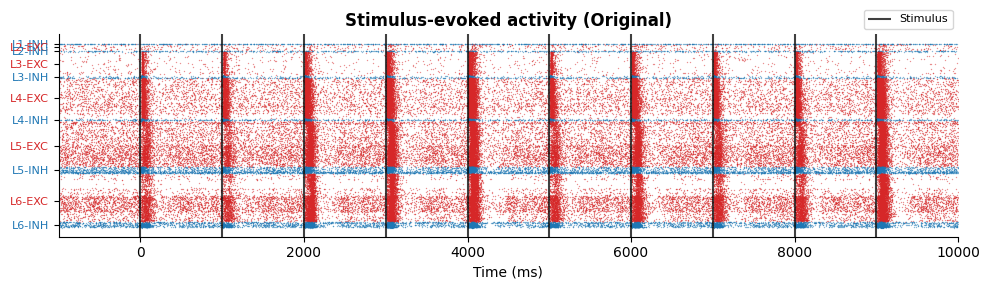

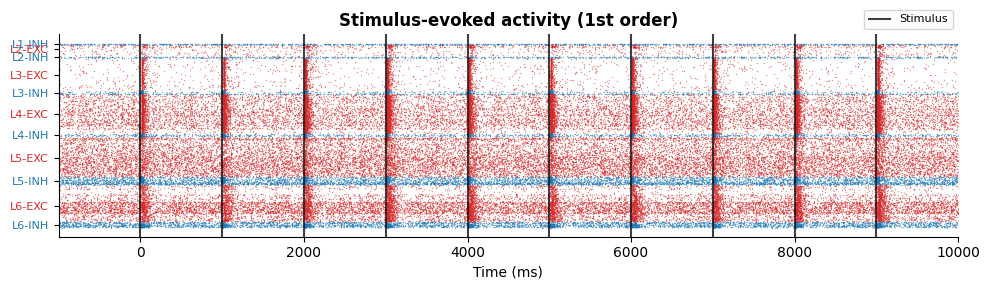

In [20]:
# Plot spike trains of all stimuli
t_start = -1000  # Rel. to t_zero (ms)
t_end = 10000  # Rel. to t_zero (ms)
t_zero = 2000  # Zero-offset (ms)

plot_spikes_per_layer(plot_names, spikes_dict['spk_exc_per_layer'], spikes_dict['spk_inh_per_layer'], t_start, t_end, t_zero, t_stim=t_stim, figsize=(10, 3), save_path=figs_path)

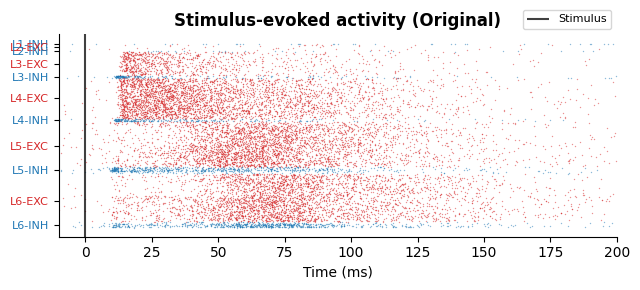

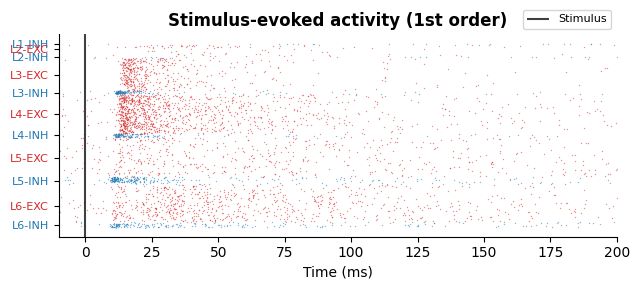

In [28]:
# Plot spike trains of last stimulus
t_start = -10 # (ms)
t_end = 200 # (ms)
t_zero = 11000

plot_spikes_per_layer(plot_names, spikes_dict['spk_exc_per_layer'], spikes_dict['spk_inh_per_layer'], t_start, t_end, t_zero, t_stim=t_stim, figsize=(6.5, 3), save_path=figs_path)

ALPHA LEVELS: *...0.01 **...0.001 ***...0.0001 

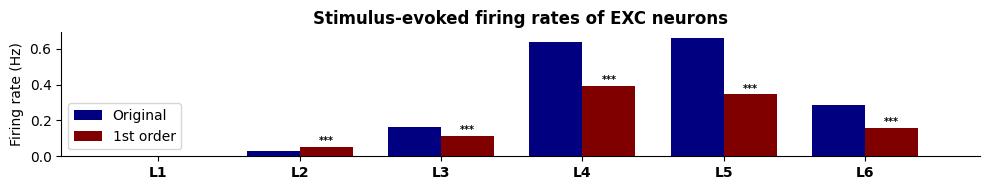

ALPHA LEVELS: *...0.01 **...0.001 ***...0.0001 

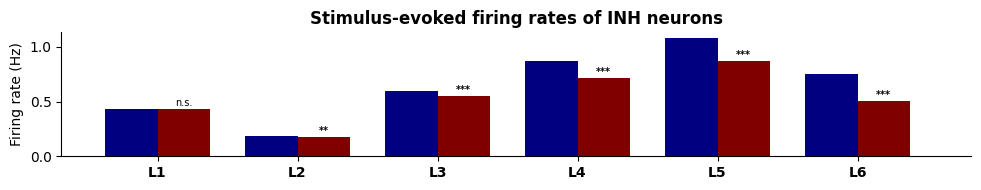

In [10]:
# Plot firing rates per layer
plot_per_layer(rates_dict['rates_exc_per_layer'], plot_names, 'Firing rate (Hz)', f'Stimulus-evoked firing rates of EXC neurons', pvals=cell_rates_pval_dict['p_rates_exc'], log_y=False, figsize=(10, 2), show_legend=True, save_path=figs_path)
plot_per_layer(rates_dict['rates_inh_per_layer'], plot_names, 'Firing rate (Hz)', f'Stimulus-evoked firing rates of INH neurons', pvals=cell_rates_pval_dict['p_rates_inh'], log_y=False, figsize=(10, 2), show_legend=False, save_path=figs_path)

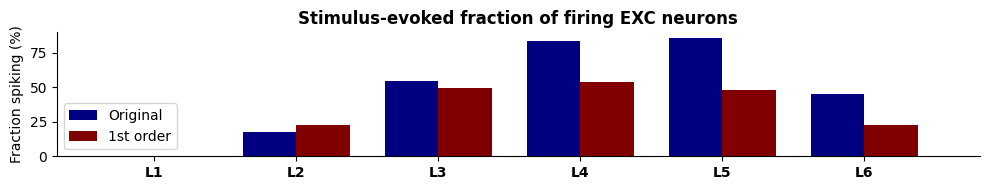

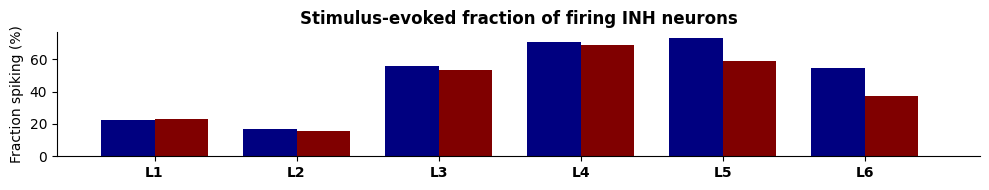

In [11]:
# Plot spiking cell fraction per layer
plot_per_layer(rates_dict['pct_exc_spiking_per_layer'], plot_names, 'Fraction spiking (%)', f'Stimulus-evoked fraction of firing EXC neurons', log_y=False, figsize=(10, 2), show_legend=True, save_path=figs_path)
plot_per_layer(rates_dict['pct_inh_spiking_per_layer'], plot_names, 'Fraction spiking (%)', f'Stimulus-evoked fraction of firing INH neurons', log_y=False, figsize=(10, 2), show_legend=False, save_path=figs_path)

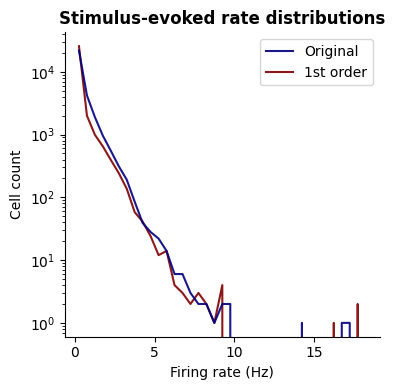

In [7]:
# Plot single-cell rate histograms
plot_cell_rate_histograms(cell_rates_dict['spk_rates'], plot_names, sim_type='Stimulus-evoked', save_path=figs_path)

In [5]:
# Compute & plot PSTHs
t_psth = [0, 200]
bin_size = 2  # (ms)
psths_exc, psths_inh, psth_bins = extract_psths(spikes_dict['spk_exc'], spikes_dict['spk_inh'], t_stim, t_psth, bin_size)
psths_exc_per_layer, psths_inh_per_layer, _ = extract_psths_per_layer(spikes_dict['spk_exc_per_layer'], spikes_dict['spk_inh_per_layer'], t_stim, t_psth, bin_size)

/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-analysis/simplified_connectome_models/notebooks/utils.py:329: RuntimeWarning: invalid value encountered in divide
  psth_exc = 1e3 * np.histogram(stim_spikes_exc.index, bins=bins)[0] / (bin_size * n_exc * len(t_stim))
/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/sscx-analysis/simplified_connectome_models/notebooks/utils.py:329: RuntimeWarning: invalid value encountered in divide
  psth_exc = 1e3 * np.histogram(stim_spikes_exc.index, bins=bins)[0] / (bin_size * n_exc * len(t_stim))


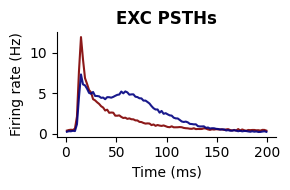

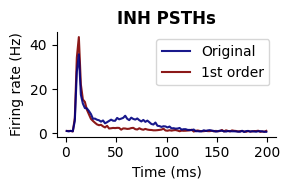

In [6]:
plot_psths(psths_exc, psth_bins, plot_names, 'EXC', figsize=(3, 2), save_path=figs_path, show_legend=False)
plot_psths(psths_inh, psth_bins, plot_names, 'INH', figsize=(3, 2), save_path=figs_path)

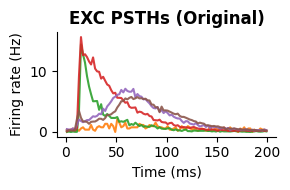

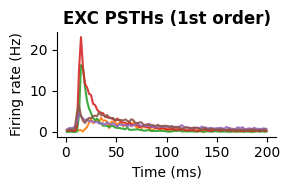

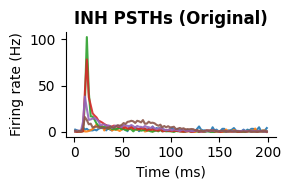

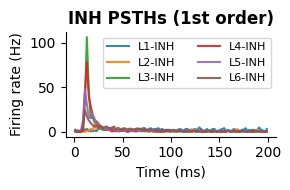

In [11]:
plot_psths_per_layer(psths_exc_per_layer, psth_bins, plot_names, 'EXC', figsize=(3, 2), save_path=figs_path, show_legend=False)
plot_psths_per_layer(psths_inh_per_layer, psth_bins, plot_names, 'INH', figsize=(3, 2), save_path=figs_path, show_legend=[False, True], lgd_props={'ncols': 2, 'fontsize': 8})

In [ ]:
# Trim PNGs
# mogrify -trim *.png